In [1]:
from pathlib import Path
from collections import Counter, defaultdict
import os, json, time, gzip, difflib

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F


In [2]:
def ensure_dir(path: Path):
    path.mkdir(parents=True, exist_ok=True)

def load_yaml(path: Path):
    import yaml
    with open(path, "r", encoding="utf-8") as f:
        return yaml.safe_load(f)

def load_json(path: Path):
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def find_project_root(start: Path = None) -> Path:
    if start is None:
        start = Path.cwd()
    for p in [start] + list(start.parents):
        if (p / "code").exists() and (p / "data").exists() and (p / "output").exists():
            return p
    for p in [start] + list(start.parents):
        if (p / "data" / "raw").exists():
            return p
    return start

def open_maybe_gz(path: Path):
    return gzip.open(path, "rt", encoding="utf-8", errors="ignore") if str(path).endswith(".gz") else open(path, "rt", encoding="utf-8", errors="ignore")

def detect_delimiter(path: Path):
    with open_maybe_gz(path) as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            return "\t" if "\t" in line else ","
    return "\t"

def iter_edges(path: Path, delim: str):
    with open_maybe_gz(path) as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split(delim)
            if len(parts) < 3:
                continue
            yield parts[0].strip(), parts[1].strip(), parts[2].strip()

def pick_latest_test_file(raw_dir: Path):
    cands = sorted(raw_dir.glob("drkg_test_holdout_*.tsv"), key=lambda p: p.stat().st_mtime, reverse=True)
    return cands[0] if cands else None


In [3]:
project_root = find_project_root()
os.chdir(project_root)
print("CWD:", Path.cwd())

cfg = load_yaml(Path("code") / "config.yaml")

proc_dir = Path(cfg["data"]["processed_dir"])
out_dir  = Path(cfg["output"]["dir"])

g = torch.load(proc_dir / "graph_edges.pt", map_location="cpu")
edge_index = g["edge_index"]
edge_type  = g["edge_type"]
num_nodes  = int(g["num_nodes"])
num_relations = int(g["num_relations"])

id2entity   = load_json(proc_dir / "id2entity.json")
id2relation = load_json(proc_dir / "id2relation.json")
entity2id   = {v: int(k) for k, v in id2entity.items()}
relation2id = {v: int(k) for k, v in id2relation.items()}

print("num_nodes:", num_nodes, "| num_relations:", num_relations, "| E:", edge_index.shape[1])
print("processed_dir:", proc_dir)
print("models_dir:", out_dir / "models")


CWD: D:\Shiraz University\HomeWorks\Ostad Moosavi\LinkPrediction
num_nodes: 37614 | num_relations: 107 | E: 118308
processed_dir: data\processed
models_dir: output\models


In [4]:
# Use train graph if available
keep_path = proc_dir / "train_graph_edge_idx.npy"
if keep_path.exists():
    keep_idx = np.load(keep_path).astype(np.int64)
    keep_idx = keep_idx[keep_idx < edge_index.shape[1]]
    ei_train = edge_index[:, keep_idx]
    et_train = edge_type[keep_idx]
    print("Using TRAIN graph:", ei_train.shape, et_train.shape)
else:
    ei_train = edge_index
    et_train = edge_type
    print("Using FULL graph:", ei_train.shape, et_train.shape)

# entity prefixes for filtering (based on DRKG convention)
head_type = cfg.get("splits", {}).get("head_type", "Compound")
tail_type = cfg.get("splits", {}).get("tail_type", "Disease")
HEAD_PREFIX = head_type + "::"
TAIL_PREFIX = tail_type + "::"

tail_candidates = [eid for ent, eid in entity2id.items() if ent.startswith(TAIL_PREFIX)]
print("tail_candidates:", len(tail_candidates), "| example:", [id2entity[str(tail_candidates[0])] if tail_candidates else None])

# Build existing head-tail pairs from train graph (only for head->tail type)
ei_np = ei_train.numpy()
existing_pairs = set()
for i in range(ei_np.shape[1]):
    h = int(ei_np[0, i]); t = int(ei_np[1, i])
    eh = id2entity.get(str(h), "")
    et = id2entity.get(str(t), "")
    if eh.startswith(HEAD_PREFIX) and et.startswith(TAIL_PREFIX):
        existing_pairs.add((h, t))

print("existing head-tail pairs (train):", len(existing_pairs))


Using TRAIN graph: torch.Size([2, 118233]) torch.Size([118233])
tail_candidates: 1867 | example: ['Disease::MESH:D007027']
existing head-tail pairs (train): 4172


In [5]:
raw_dir = Path("data") / "raw"
test_path = pick_latest_test_file(raw_dir)

# اگر دوست داری دستی انتخاب کنی:
# test_path = raw_dir / "drkg_test_holdout_20k.tsv"

if test_path is None or not test_path.exists():
    raise FileNotFoundError("هیچ فایل drkg_test_holdout_*.tsv داخل data/raw پیدا نشد. اول نوت‌بوک 10 را اجرا کن.")

delim = detect_delimiter(test_path)
print("Test file:", test_path, "| delim:", "TAB" if delim=="\t" else "COMMA")

target_substrings = cfg.get("task", {}).get("target_relation_substrings", []) or []
target_substrings = [s.lower() for s in target_substrings]
print("target_relation_substrings:", target_substrings)

pos_h = []
pos_t = []
pos_r = []

n_total = 0
n_kept = 0
n_unknown = 0
n_type_filtered = 0
n_rel_filtered = 0

for h_str, r_str, t_str in iter_edges(test_path, delim):
    n_total += 1

    # type filter (Compound->Disease by default)
    if (not h_str.startswith(HEAD_PREFIX)) or (not t_str.startswith(TAIL_PREFIX)):
        n_type_filtered += 1
        continue

    # relation substring filter (if provided and matches at least one)
    if len(target_substrings) > 0:
        if not any(ss in r_str.lower() for ss in target_substrings):
            n_rel_filtered += 1
            continue

    if h_str not in entity2id or t_str not in entity2id:
        n_unknown += 1
        continue

    hid = int(entity2id[h_str])
    tid = int(entity2id[t_str])

    # disjoint safety: skip if in train graph
    if (hid, tid) in existing_pairs:
        continue

    pos_h.append(hid)
    pos_t.append(tid)
    pos_r.append(r_str)
    n_kept += 1

print("Total lines:", n_total)
print("Kept positives:", n_kept)
print("Filtered by type:", n_type_filtered)
print("Filtered by relation:", n_rel_filtered)
print("Unknown entities:", n_unknown)

if n_kept == 0:
    # اگر relation filter خیلی سخت بود، یکبار بدون آن ادامه بده
    raise ValueError("هیچ نمونه‌ی مثبت برای تست باقی نماند. احتمالاً target_relation_substrings با relation های فایل تست شما همخوانی ندارد. "
                     "یا target_relation_substrings را خالی کن، یا require_relations... را خاموش کن، یا فایل تست را برای همان relation بساز.")

test_pos = torch.tensor([pos_h, pos_t], dtype=torch.long)
print("test_pos shape:", tuple(test_pos.shape))


Test file: data\raw\drkg_test_holdout_20k.tsv | delim: TAB
target_relation_substrings: ['treats']
Total lines: 19592
Kept positives: 105
Filtered by type: 18496
Filtered by relation: 990
Unknown entities: 0
test_pos shape: (2, 105)


In [6]:
def sample_negatives(heads, tail_candidates, existing_pairs, num_negs_per_pos=50, seed=42):
    rng = np.random.default_rng(seed)
    heads = np.asarray(heads, dtype=np.int64)
    tails_out = []
    heads_out = []
    # for ranking: store per-pos negatives indices
    negs_per_pos = []

    tc = np.asarray(tail_candidates, dtype=np.int64)
    for h in heads:
        negs = []
        tries = 0
        while len(negs) < num_negs_per_pos:
            tries += 1
            if tries > num_negs_per_pos * 200:
                # avoid infinite loop in dense graphs
                break
            t = int(tc[rng.integers(0, len(tc))])
            if (h, t) in existing_pairs:
                continue
            negs.append(t)
        negs_per_pos.append(negs)
        for t in negs:
            heads_out.append(int(h))
            tails_out.append(int(t))

    neg_pairs = torch.tensor([heads_out, tails_out], dtype=torch.long)
    return neg_pairs, negs_per_pos

num_negs = int(cfg.get("splits", {}).get("num_negs_per_pos_eval", 50))
test_neg, negs_per_pos = sample_negatives(
    heads=test_pos[0].numpy(),
    tail_candidates=tail_candidates,
    existing_pairs=existing_pairs.union(set(zip(pos_h, pos_t))),
    num_negs_per_pos=num_negs,
    seed=int(cfg.get("seed", 42))
)
print("test_neg shape:", tuple(test_neg.shape), "| negs_per_pos[0] len:", len(negs_per_pos[0]))


test_neg shape: (2, 5250) | negs_per_pos[0] len: 50


In [7]:
try:
    from torch_geometric.nn import GATConv, RGCNConv, RGATConv
except Exception as e:
    raise ImportError("torch_geometric نصب نیست. اول torch_geometric را نصب کن.") from e


class MLPLinkScorer(nn.Module):
    """Flexible scorer: in_mult inferred from checkpoint."""
    def __init__(self, dim: int, hidden: int = 128, dropout: float = 0.2, in_mult: int = 2):
        super().__init__()
        self.dim = int(dim)
        self.in_mult = int(in_mult)
        self.net = nn.Sequential(
            nn.Linear(self.dim * self.in_mult, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, 1),
        )

    def forward(self, z: torch.Tensor, heads: torch.Tensor, tails: torch.Tensor) -> torch.Tensor:
        h = z[heads]
        t = z[tails]
        if self.in_mult == 2:
            x = torch.cat([h, t], dim=1)
        elif self.in_mult == 3:
            x = torch.cat([h, t, h * t], dim=1)
        elif self.in_mult == 4:
            x = torch.cat([h, t, torch.abs(h - t), h * t], dim=1)
        else:
            x = torch.cat([h, t], dim=1)
        return self.net(x).view(-1)


class GATEncoder(nn.Module):
    def __init__(self, num_nodes, dim=64, heads=4, dropout=0.2):
        super().__init__()
        self.emb = nn.Embedding(num_nodes, dim)
        self.dropout = dropout
        self.conv1 = GATConv(dim, dim, heads=heads, dropout=dropout, concat=True)
        self.conv2 = GATConv(dim * heads, dim, heads=1, dropout=dropout, concat=False)

    def forward(self, edge_index):
        x = self.emb.weight
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x


class RGCNEncoder(nn.Module):
    def __init__(self, num_nodes, num_relations, dim=128, dropout=0.2, num_bases=None):
        super().__init__()
        self.emb = nn.Embedding(num_nodes, dim)
        self.dropout = dropout
        self.conv1 = RGCNConv(dim, dim, num_relations, num_bases=num_bases)
        self.conv2 = RGCNConv(dim, dim, num_relations, num_bases=num_bases)

    def forward(self, edge_index, edge_type):
        x = self.emb.weight
        x = self.conv1(x, edge_index, edge_type)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index, edge_type)
        return x


class RGATEncoder(nn.Module):
    def __init__(self, num_nodes, num_relations, dim=32, heads=2, dropout=0.2, num_bases=8):
        super().__init__()
        self.emb = nn.Embedding(num_nodes, dim)
        self.dropout = dropout
        self.conv1 = RGATConv(dim, dim, num_relations=num_relations, heads=heads, concat=True,
                              dropout=dropout, num_bases=num_bases)
        self.conv2 = RGATConv(dim * heads, dim, num_relations=num_relations, heads=1, concat=False,
                              dropout=dropout, num_bases=num_bases)

    def forward(self, edge_index, edge_type):
        x = self.emb.weight
        x = self.conv1(x, edge_index, edge_type)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index, edge_type)
        return x


def _rename_prefix(sd: dict, src: str, dst: str) -> dict:
    out = {}
    for k, v in sd.items():
        if k.startswith(src + "."):
            out[dst + k[len(src):]] = v
        else:
            out[k] = v
    return out

def _infer_scorer_in_mult(sd_sc: dict, dim: int):
    key = None
    for cand in ["net.0.weight", "mlp.0.weight"]:
        if cand in sd_sc:
            key = cand
            break
    if key is None:
        for k in sd_sc.keys():
            if k.endswith(".0.weight"):
                key = k
                break
    if key is None:
        return 2, 128
    in_features = int(sd_sc[key].shape[1])
    hidden = int(sd_sc[key].shape[0])
    in_mult = max(1, in_features // int(dim))
    return in_mult, hidden

def _infer_gat_heads(sd_enc: dict, dim: int):
    # PyG att_src shape: [1, heads, out_channels]
    for k in ["conv1.att_src", "conv1.att_dst", "conv1.att_l", "conv1.att"]:
        if k in sd_enc:
            t = sd_enc[k]
            if t.dim() >= 2:
                return int(t.shape[1])
            return int(t.shape[0])
    if "conv1.bias" in sd_enc:
        b = sd_enc["conv1.bias"]
        if b.numel() % int(dim) == 0:
            return int(b.numel() // int(dim))
    for k in ["conv1.lin_src.weight", "conv1.lin.weight", "conv1.lin_l.weight"]:
        if k in sd_enc:
            w = sd_enc[k]
            if w.shape[0] % int(dim) == 0:
                return int(w.shape[0] // int(dim))
    return 2

def _infer_rgcn_num_bases(sd_enc: dict):
    if "conv1.comp" in sd_enc and "conv1.weight" in sd_enc:
        return int(sd_enc["conv1.weight"].shape[0])
    return None

def _infer_rgat_heads_bases(sd_enc: dict):
    heads = None
    if "conv1.q" in sd_enc:
        heads = int(sd_enc["conv1.q"].shape[1])
    num_bases = int(sd_enc["conv1.basis"].shape[0]) if "conv1.basis" in sd_enc else 8
    return heads, num_bases

def find_ckpt(models_dir: Path, model_name: str):
    p = models_dir / f"{model_name}.pt"
    if p.exists():
        return p
    cands = sorted(models_dir.glob(f"*{model_name}*.pt"))
    return cands[0] if cands else None

def load_model(model_name: str, cfg: dict, g: dict, models_dir: Path):
    ckpt_path = find_ckpt(models_dir, model_name)
    if ckpt_path is None:
        return None, None, None, None

    ckpt = torch.load(ckpt_path, map_location="cpu")
    sd_enc = ckpt["encoder"]
    sd_sc  = ckpt["scorer"]

    dim = int(sd_enc["emb.weight"].shape[1])
    dropout = float(cfg.get("model", {}).get("dropout", 0.2))

    # normalize scorer prefix
    if any(k.startswith("mlp.") for k in sd_sc.keys()) and not any(k.startswith("net.") for k in sd_sc.keys()):
        sd_sc = _rename_prefix(sd_sc, "mlp", "net")

    in_mult, hidden = _infer_scorer_in_mult(sd_sc, dim)
    scorer = MLPLinkScorer(dim=dim, hidden=hidden, dropout=dropout, in_mult=in_mult)
    scorer.load_state_dict(sd_sc, strict=True)

    if model_name == "gat":
        heads = _infer_gat_heads(sd_enc, dim)
        encoder = GATEncoder(num_nodes=int(g["num_nodes"]), dim=dim, heads=heads, dropout=dropout)
        encoder.load_state_dict(sd_enc, strict=True)
        return encoder, scorer, ckpt_path, {"dim": dim, "heads": heads, "in_mult": in_mult}

    if model_name == "rgcn":
        num_bases = _infer_rgcn_num_bases(sd_enc)
        encoder = RGCNEncoder(num_nodes=int(g["num_nodes"]), num_relations=int(g["num_relations"]),
                              dim=dim, dropout=dropout, num_bases=num_bases)
        encoder.load_state_dict(sd_enc, strict=True)
        return encoder, scorer, ckpt_path, {"dim": dim, "num_bases": num_bases, "in_mult": in_mult}

    if model_name == "rgat":
        heads, num_bases = _infer_rgat_heads_bases(sd_enc)
        if heads is None:
            heads = int(cfg.get("model", {}).get("rgat_heads", 2))
        encoder = RGATEncoder(num_nodes=int(g["num_nodes"]), num_relations=int(g["num_relations"]),
                              dim=dim, heads=heads, dropout=dropout, num_bases=num_bases)
        encoder.load_state_dict(sd_enc, strict=True)
        return encoder, scorer, ckpt_path, {"dim": dim, "heads": heads, "num_bases": num_bases, "in_mult": in_mult}

    return None, None, None, None


D:\Shiraz University\HomeWorks\Ostad Moosavi\LinkPrediction\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() and cfg.get("train", {}).get("use_cuda", True) else "cpu")
print("device:", device)

models_dir = out_dir / "models"
models = {}

for name in ["gat", "rgcn", "rgat"]:
    enc, sc, path, info = load_model(name, cfg, g, models_dir)
    if enc is None:
        print(f"[{name}] not found -> skip")
        continue
    enc.to(device).eval()
    sc.to(device).eval()
    models[name] = {"encoder": enc, "scorer": sc, "path": path, "info": info}
    print(f"[{name}] loaded:", path.name, "| info:", info)

if len(models) == 0:
    raise RuntimeError("No models loaded. Check output/models.")

ei_train_d = ei_train.to(device)
et_train_d = et_train.to(device)

@torch.no_grad()
def compute_z(model_name: str, encoder, ei, et):
    if model_name == "gat":
        return encoder(ei)
    if model_name == "rgcn":
        return encoder(ei, et)
    if model_name == "rgat":
        return encoder(ei, et)
    return None

Z = {}
for name, m in models.items():
    print("Computing embeddings:", name)
    Z[name] = compute_z(name, m["encoder"], ei_train_d, et_train_d)
    print(" z:", tuple(Z[name].shape))


device: cpu
[gat] loaded: gat.pt | info: {'dim': 128, 'heads': 4, 'in_mult': 3}
[rgcn] loaded: rgcn.pt | info: {'dim': 128, 'num_bases': 30, 'in_mult': 3}
[rgat] loaded: rgat.pt | info: {'dim': 32, 'heads': 2, 'num_bases': 8, 'in_mult': 3}
Computing embeddings: gat
 z: (37614, 128)
Computing embeddings: rgcn
 z: (37614, 128)
Computing embeddings: rgat
 z: (37614, 32)


In [9]:
@torch.no_grad()
def score_pairs(model_name: str, pairs: torch.Tensor, batch_size: int = 8192):
    """pairs: [2, N]"""
    z = Z[model_name]
    scorer = models[model_name]["scorer"]
    N = pairs.shape[1]
    out = []
    for s in range(0, N, batch_size):
        h = pairs[0, s:s+batch_size].to(device)
        t = pairs[1, s:s+batch_size].to(device)
        logits = scorer(z, h, t).detach().cpu()
        out.append(logits)
    logits = torch.cat(out, dim=0)
    probs = torch.sigmoid(logits)
    return logits.numpy(), probs.numpy()

def binary_metrics(y_true, y_prob):
    y_true = np.asarray(y_true, dtype=np.int64)
    y_prob = np.asarray(y_prob, dtype=np.float64)
    y_pred = (y_prob >= 0.5).astype(np.int64)
    acc = float((y_pred == y_true).mean())

    roc_auc = None
    pr_auc = None
    try:
        from sklearn.metrics import roc_auc_score, average_precision_score
        roc_auc = float(roc_auc_score(y_true, y_prob)) if len(np.unique(y_true)) > 1 else None
        pr_auc  = float(average_precision_score(y_true, y_prob)) if len(np.unique(y_true)) > 1 else None
    except Exception as e:
        print("sklearn not available for AUC/PR-AUC:", e)

    return {"accuracy@0.5": acc, "roc_auc": roc_auc, "pr_auc": pr_auc}

@torch.no_grad()
def ranking_metrics(model_name: str, pos_pairs: torch.Tensor, negs_per_pos: list, K: int = 10, batch_size: int = 2048):
    """Compute MRR & Hits@K using sampled negatives per positive."""
    z = Z[model_name]
    scorer = models[model_name]["scorer"]

    mrr_sum = 0.0
    hits = 0
    n = pos_pairs.shape[1]

    # process in chunks
    for s in range(0, n, batch_size):
        e = min(n, s + batch_size)
        bh = pos_pairs[0, s:e].to(device)
        bt = pos_pairs[1, s:e].to(device)

        pos_logits = scorer(z, bh, bt)  # [B]

        # build candidate tails tensor [B, 1+num_negs]
        cand_tails = []
        for i in range(s, e):
            cand = [int(pos_pairs[1, i])] + [int(x) for x in negs_per_pos[i]]
            cand_tails.append(cand)
        cand_tails = torch.tensor(cand_tails, dtype=torch.long, device=device)  # [B, C]
        cand_heads = bh.unsqueeze(1).expand_as(cand_tails)  # [B, C]

        # score all candidates
        B, C = cand_tails.shape
        logits_all = scorer(z, cand_heads.reshape(-1), cand_tails.reshape(-1)).reshape(B, C)

        # rank true tail (index 0) among C (descending)
        # handle ties: rank = 1 + #neg>pos + 0.5*#neg==pos
        pos = logits_all[:, 0]
        neg = logits_all[:, 1:]

        greater = (neg > pos.unsqueeze(1)).sum(dim=1).float()
        equal   = (neg == pos.unsqueeze(1)).sum(dim=1).float()
        rank = 1.0 + greater + 0.5 * equal

        mrr_sum += float((1.0 / rank).sum().item())
        hits += int((rank <= K).sum().item())

    return {"mrr": mrr_sum / max(1, n), f"hits@{K}": hits / max(1, n)}


In [10]:
metrics_dir = out_dir / "metrics" / "external_test"
ensure_dir(metrics_dir)

K = int(cfg.get("attention", {}).get("topk_relations_plot", 10))  # just reuse something; you can set K manually below
K = 10

# Build y for binary metrics
y_true = np.concatenate([np.ones(test_pos.shape[1], dtype=np.int64), np.zeros(test_neg.shape[1], dtype=np.int64)])
pairs_all = torch.cat([test_pos, test_neg], dim=1)

results = []
for name in models.keys():
    logits, probs = score_pairs(name, pairs_all, batch_size=8192)
    m_bin = binary_metrics(y_true, probs)

    m_rank = ranking_metrics(name, test_pos, negs_per_pos, K=K, batch_size=512)

    m = {"model": name, "test_pos": int(test_pos.shape[1]), "test_neg": int(test_neg.shape[1])}
    m.update(m_bin)
    m.update(m_rank)

    results.append(m)

    with open(metrics_dir / f"metrics_{name}.json", "w", encoding="utf-8") as f:
        json.dump(m, f, indent=2, ensure_ascii=False)

df = pd.DataFrame(results).sort_values("roc_auc", ascending=False)
df.to_csv(metrics_dir / "comparison.csv", index=False)

print("Saved:", metrics_dir / "comparison.csv")
df


Saved: output\metrics\external_test\comparison.csv


,model,test_pos,test_neg,accuracy@0.5,roc_auc,pr_auc,mrr,hits@10
2,rgat,105,5250,0.868161,0.726220,0.065150,0.256223,0.552381
1,rgcn,105,5250,0.909057,0.712103,0.076512,0.268502,0.561905
0,gat,105,5250,0.871335,0.697332,0.048507,0.200613,0.514286


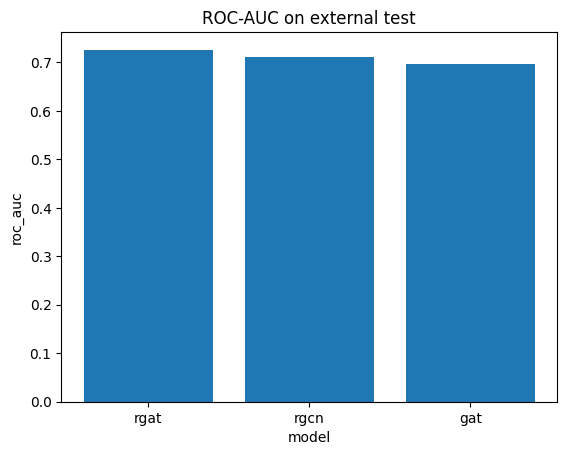

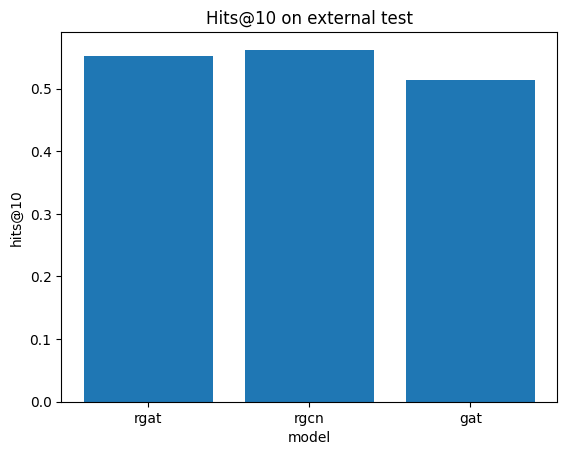

In [11]:
import matplotlib.pyplot as plt

if len(df) > 0:
    # plot ROC-AUC and Hits@K
    plt.figure()
    plt.bar(df["model"], df["roc_auc"])
    plt.title("ROC-AUC on external test")
    plt.xlabel("model")
    plt.ylabel("roc_auc")
    plt.show()

    plt.figure()
    plt.bar(df["model"], df[f"hits@{K}"])
    plt.title(f"Hits@{K} on external test")
    plt.xlabel("model")
    plt.ylabel(f"hits@{K}")
    plt.show()
